In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import cross_validate, LeaveOneGroupOut
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
import sklearn
%matplotlib inline

## Load Subject Data

In [2]:
BASE_PATH = 'segmented_data'

In [76]:
# subjects_data = [pd.read_feather(os.path.join(BASE_PATH, subject)) for subject in os.listdir(BASE_PATH)]
# df = pd.concat(subjects_data)
# df.drop(columns=['index'], inplace=True)
# df.shape

In [67]:
# df.to_csv('segmented_data/all_subjects.csv')

In [3]:
df = pd.read_csv(f'{BASE_PATH}/all_subjects.csv', index_col=0)

In [4]:
df.shape

(121813, 79)

In [5]:
df.head()

,ACC_x_absint,ACC_x_mean,ACC_x_peak,ACC_x_std,ACC_xyz_absint,ACC_xyz_std,ACC_xzy_mean,ACC_y_absint,ACC_y_mean,ACC_y_peak,...,RESP_stretch,RESP_volume,TEMP_drange,TEMP_max,TEMP_mean,TEMP_min,TEMP_slope,TEMP_std,label,subject
0,33018.685611,0.786178,0.8766,0.030389,13233.532886,21266.015893,6736.963395,6256.039785,0.148957,0.2504,...,10.783828,125.194862,1.010598,35.171936,34.988750,34.803101,-0.000002,0.054536,3,S8
1,33012.188012,0.786023,0.8766,0.030383,13228.857486,21267.760722,6732.487596,6260.111985,0.149054,0.2504,...,10.783828,125.194862,1.010598,35.171936,34.988785,34.803101,-0.000002,0.054524,3,S8
2,33006.168612,0.785880,0.8766,0.030367,13225.533786,21268.840449,6728.895262,6264.232385,0.149152,0.2504,...,10.783828,125.194862,1.010598,35.171936,34.988869,34.803101,-0.000002,0.054485,3,S8
3,33005.078112,0.785855,0.8766,0.030379,13228.145587,21269.264878,6729.222863,6268.463386,0.149253,0.2504,...,10.783828,125.194862,1.010598,35.171936,34.988983,34.803101,-0.000002,0.054432,3,S8
4,33008.020712,0.785926,0.9390,0.030564,13234.658287,21268.410145,6732.741796,6270.908585,0.149312,0.2504,...,10.783828,119.178477,1.010598,35.171936,34.989079,34.803101,-0.000002,0.054387,3,S8


In [6]:
df.columns

Index(['ACC_x_absint', 'ACC_x_mean', 'ACC_x_peak', 'ACC_x_std',
       'ACC_xyz_absint', 'ACC_xyz_std', 'ACC_xzy_mean', 'ACC_y_absint',
       'ACC_y_mean', 'ACC_y_peak', 'ACC_y_std', 'ACC_z_absint', 'ACC_z_mean',
       'ACC_z_peak', 'ACC_z_std', 'ECG_hr_mean', 'ECG_hr_std', 'ECG_hrv_HF',
       'ECG_hrv_HFn', 'ECG_hrv_LF', 'ECG_hrv_LFHF_ratio', 'ECG_hrv_LFn',
       'ECG_hrv_NN50', 'ECG_hrv_RMS', 'ECG_hrv_TINN', 'ECG_hrv_ULF',
       'ECG_hrv_VHF', 'ECG_hrv_f_sum', 'ECG_hrv_pNN50', 'ECG_hrv_rel_HF',
       'ECG_hrv_rel_LF', 'ECG_hrv_rel_ULF', 'ECG_hrv_rel_VHF', 'EDA_SCL_mean',
       'EDA_SCL_std', 'EDA_SCR_mean', 'EDA_SCR_no', 'EDA_SCR_std',
       'EDA_ampl_sum', 'EDA_corr_SCL_t', 'EDA_drange', 'EDA_max', 'EDA_mean',
       'EDA_min', 'EDA_scr_area', 'EDA_slope', 'EDA_std', 'EMG_absint',
       'EMG_drange', 'EMG_mean', 'EMG_mean_freq', 'EMG_median',
       'EMG_median_freq', 'EMG_peak_amp_mean', 'EMG_peak_amp_norm_sum',
       'EMG_peak_amp_std', 'EMG_peak_amp_sum', 'EMG_peak_freq

## Picking a modality

Prior executing the models, uncomment a modality from the following cells

In [191]:
# modality = 'ACC'
# modality = 'ECG'
# modality = 'EDA'
# modality = 'EMG'
# modality = 'RESP'
modality = 'TEMP'

In [30]:
df_report = pd.DataFrame()
df_report.loc['ACC', :] = []
df_report.loc['ECG', :] = []
df_report.loc['EDA', :] = []
df_report.loc['EMG', :] = []
df_report.loc['RESP', :] = []
df_report.loc['TEMP', :] = []

In [192]:
mod_cols = df.columns[df.columns.str.startswith(modality)]

## Splitting data for CV

In [193]:
X = df[mod_cols]
y = df['label']
y_b = y.copy().apply(lambda x: 1 if x == 2 else 0)  # stress vs non-stress
loso_cv = LeaveOneGroupOut()  # just to analyze training set sizes
for train, test in loso_cv.split(X, y, groups=df['subject']):
    print(train.shape)

(113425,)
(113621,)
(113628,)
(113624,)
(113601,)
(113648,)
(113429,)
(114049,)
(113913,)
(113872,)
(113665,)
(113725,)
(113740,)
(113697,)
(113745,)


In [194]:
X.shape

(121813, 6)

## Hyperparameters

In [195]:
n_estimators = 100
min_samples_split = 20
criterion = 'entropy'  # information gain
subjects = df['subject'].unique()

In [196]:
def run_cv(clf, X, y, groups, cv, scoring=['accuracy', 'f1_macro'], return_train_score=True,
          return_estimator=True, n_jobs=-1):
    """
        More on cross validation: https://scikit-learn.org/stable/modules/cross_validation.html#
        More on scoring: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    """
    return cross_validate(clf, X, y, groups=groups, cv=cv, scoring=scoring, return_train_score=return_train_score,
                          return_estimator=return_estimator, n_jobs=n_jobs)
def raw_scores(cv):
    return np.mean(cv['test_accuracy']), np.mean(cv['test_f1_macro'])

def test_score(cv):
    return {
        'accuracy': f"{np.mean(cv['test_accuracy'])} +-{np.std(cv['test_accuracy'])}",
        'f1_macro': f"{np.mean(cv['test_f1_macro'])} +-{np.std(cv['test_f1_macro'])}"
    }

def min_max(acc_scores):
    print(np.argmax(acc_scores), np.amax(acc_scores))
    print(np.argmin(acc_scores), np.amin(acc_scores))

# Random Forest

In [197]:
def create_rf_pipeline(n_estimators=100, min_samples_split=20, criterion='entropy', n_jobs=-1):
    model_rf =  RandomForestClassifier(n_estimators=n_estimators, min_samples_split=min_samples_split, 
                                  criterion=criterion, n_jobs=-1)
    return make_pipeline(StandardScaler(), model_rf)

### Baseline vs Stress vs Amusement

In [198]:
clf_rf_all = create_rf_pipeline(n_estimators=n_estimators, min_samples_split=min_samples_split,
                                criterion=criterion, n_jobs=-1)
cv_rf_all = run_cv(clf_rf_all, X, y, groups=df['subject'], cv=LeaveOneGroupOut())
test_score(cv_rf_all)

{'accuracy': '0.499754647995666 +-0.19306057821544867',
 'f1_macro': '0.40883665575794165 +-0.18470415760962317'}

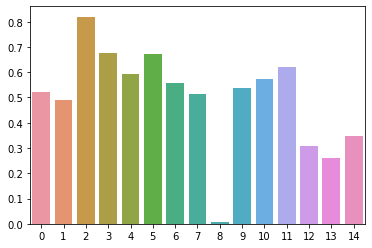

In [199]:
sns.barplot(x=list(range(len(subjects))), y=cv_rf_all['test_accuracy']);

In [200]:
min_max(cv_rf_all['test_accuracy'])

2 0.8196701282834453
8 0.005316455696202532


### Stress vs Non-Stress

In [201]:
clf_b_rf_all = create_rf_pipeline(n_estimators=n_estimators, min_samples_split=min_samples_split,
                              criterion=criterion, n_jobs=-1)
cv_b_rf_all = run_cv(clf_b_rf_all, X, y_b, groups=df['subject'], cv=LeaveOneGroupOut())
print(test_score(cv_b_rf_all))

{'accuracy': '0.6427685858944838 +-0.14943073781633812', 'f1_macro': '0.5351300574621347 +-0.17146963445978558'}


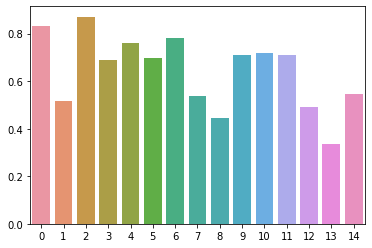

In [202]:
sns.barplot(x=list(range(len(subjects))), y=cv_b_rf_all['test_accuracy']);

In [203]:
min_max(cv_b_rf_all['test_accuracy'])

2 0.8707391569945021
13 0.33526367668802365


In [204]:
rf_acc, rf_f1 = raw_scores(cv_rf_all)
rf_b_acc, rf_b_f1 = raw_scores(cv_b_rf_all)
df_report.loc[modality, 'rf_f1'] = rf_f1
df_report.loc[modality, 'rf_acc'] = rf_acc
df_report.loc[modality, 'rf_b_f1'] = rf_b_f1
df_report.loc[modality, 'rf_b_acc'] = rf_b_acc

# AdaBoost

In [205]:
def create_ab_pipeline(n_estimators=100, min_samples_split=20, criterion='entropy'):
    base_estimator = DecisionTreeClassifier(criterion=criterion, min_samples_split=min_samples_split)
    model_ab = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=n_estimators)
    return make_pipeline(StandardScaler(), model_ab)

### Baseline vs Stress vs Amusement

In [206]:
clf_ab_all = create_ab_pipeline()
cv_ab_all = run_cv(clf_ab_all, X, y, groups=df['subject'], cv=LeaveOneGroupOut())
test_score(cv_ab_all)

{'accuracy': '0.4947611645544441 +-0.17061247031579288',
 'f1_macro': '0.386726902486435 +-0.15451625574115885'}

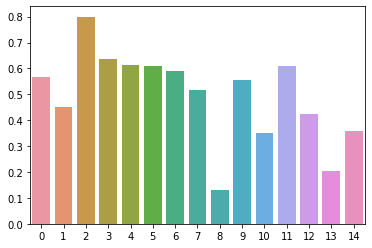

In [207]:
sns.barplot(x=list(range(len(subjects))), y=cv_ab_all['test_accuracy']);

In [208]:
min_max(cv_ab_all['test_accuracy'])

2 0.7997556505803298
8 0.12974683544303797


### Stress vs Non-stress

In [209]:
clf_b_ab_all = create_ab_pipeline()
cv_b_ab_all = run_cv(clf_b_ab_all, X, y_b, groups=df['subject'], cv=LeaveOneGroupOut())
test_score(cv_b_ab_all)

{'accuracy': '0.6147497201006527 +-0.15978252785041336',
 'f1_macro': '0.5004780403703463 +-0.15670744402557127'}

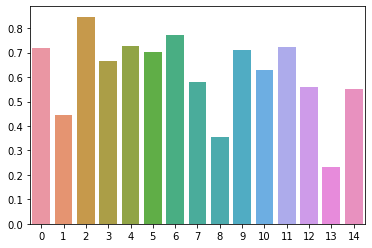

In [210]:
sns.barplot(x=list(range(len(subjects))), y=cv_b_ab_all['test_accuracy']);

In [211]:
min_max(cv_b_ab_all['test_accuracy'])

2 0.8467929138668295
13 0.23410547067520945


In [212]:
ab_acc, ab_f1 = raw_scores(cv_ab_all)
ab_b_acc, ab_b_f1 = raw_scores(cv_b_ab_all)
df_report.loc[modality, 'ab_f1'] = ab_f1
df_report.loc[modality, 'ab_acc'] = ab_acc
df_report.loc[modality, 'ab_b_f1'] = ab_b_f1
df_report.loc[modality, 'ab_b_acc'] = ab_b_acc

# LDA

In [213]:
def create_lda_pipeline():
    return make_pipeline(StandardScaler(), LDA())

### Baseline vs Stress vs Non-stress

In [214]:
model_lda_all = create_lda_pipeline()
cv_lda_all = run_cv(model_lda_all, X, y, groups=df['subject'], cv=LeaveOneGroupOut())
test_score(cv_lda_all)

{'accuracy': '0.5754434914420609 +-0.06968548217118739',
 'f1_macro': '0.2897186265347211 +-0.10195462544511139'}

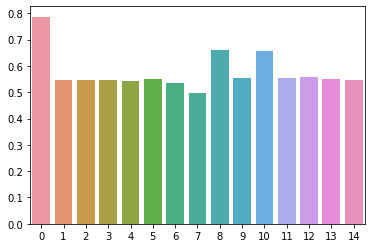

In [215]:
sns.barplot(x=list(range(len(subjects))), y=cv_lda_all['test_accuracy']);

In [216]:
min_max(cv_lda_all['test_accuracy'])

0 0.7867191225560324
7 0.49806800618238023


### Stress vs Non-Stress

In [217]:
model_b_lda_all = create_lda_pipeline()
cv_b_lda_all = run_cv(model_b_lda_all, X, y_b, groups=df['subject'], cv=LeaveOneGroupOut())
test_score(cv_b_lda_all)

{'accuracy': '0.7052835593936336 +-0.03168774005457038',
 'f1_macro': '0.43031788404186333 +-0.07263065593746956'}

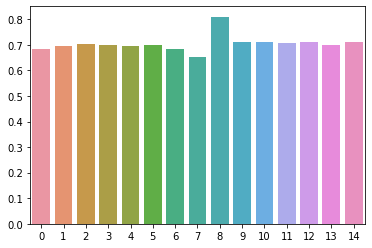

In [218]:
sns.barplot(x=list(range(len(subjects))), y=cv_b_lda_all['test_accuracy']);

In [219]:
min_max(cv_b_lda_all['test_accuracy'])

8 0.809873417721519
7 0.6531427099433282


In [220]:
lda_acc, lda_f1 = raw_scores(cv_lda_all)
lda_b_acc, lda_b_f1 = raw_scores(cv_b_lda_all)
df_report.loc[modality, 'lda_f1'] = lda_f1
df_report.loc[modality, 'lda_acc'] = lda_acc
df_report.loc[modality, 'lda_b_f1'] = lda_b_f1
df_report.loc[modality, 'lda_b_acc'] = lda_b_acc

## Results

In [221]:
df_report

,rf_f1,rf_acc,rf_b_f1,rf_b_acc,ab_f1,ab_acc,ab_b_f1,ab_b_acc,lda_f1,lda_acc,lda_b_f1,lda_b_acc
ACC,0.395361,0.559278,0.569841,0.723911,0.448804,0.591598,0.588321,0.733027,0.400382,0.597001,0.542222,0.700070
ECG,0.518569,0.660007,0.796300,0.839966,0.515433,0.662472,0.800814,0.844100,0.515813,0.708160,0.809485,0.865115
EDA,0.643974,0.667019,0.749781,0.787745,0.621201,0.645761,0.741442,0.781814,0.451855,0.574640,0.692621,0.764252
EMG,0.462594,0.607954,0.599067,0.713775,0.480842,0.620192,0.610554,0.723836,0.445108,0.599009,0.614172,0.724727
RESP,0.545764,0.676278,0.786080,0.824339,0.544442,0.682530,0.785471,0.821546,0.545973,0.698706,0.796305,0.841577
TEMP,0.408837,0.499755,0.535130,0.642769,0.386727,0.494761,0.500478,0.614750,0.289719,0.575443,0.430318,0.705284


In [222]:
df_report.to_csv('chest_scores_per_mod.csv')

In [1]:
# df_report.to_markdown()